<a href="https://colab.research.google.com/github/stxupengyu/time-series-analysis/blob/master/time_series_analysis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#安装相关库
!pip install arch
#加载相关库
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

     |████████████████████████████████| 808kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
#使用pandas_datareader包通过Yahoo Finance API来获取一些示例数据。
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

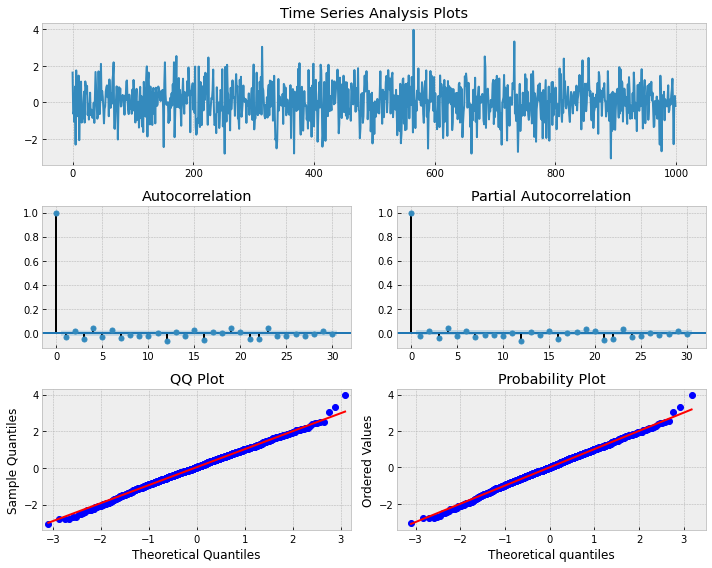

In [3]:
#让我们模拟白噪声过程并进行查看。下面我介绍一个方便的函数，用于绘制时间序列并直观地分析序列相关性。
#我们可以轻松地为白噪声过程建模，并输出TS图以进行视觉检查。 
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [4]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


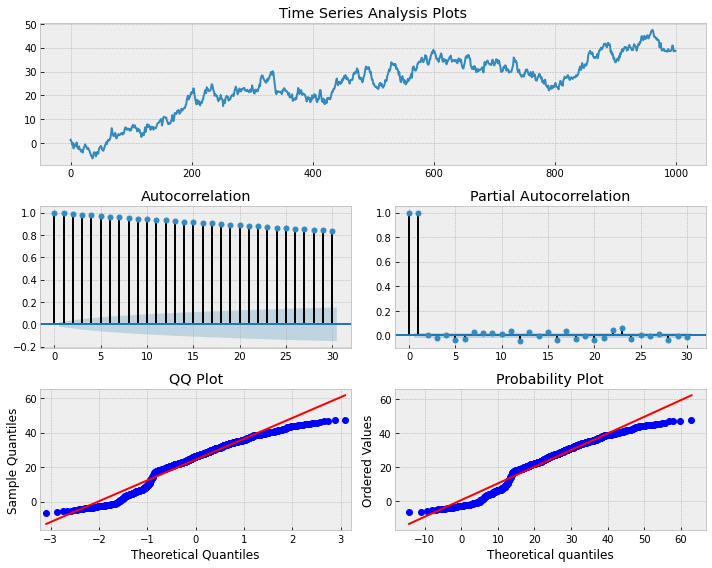

In [5]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

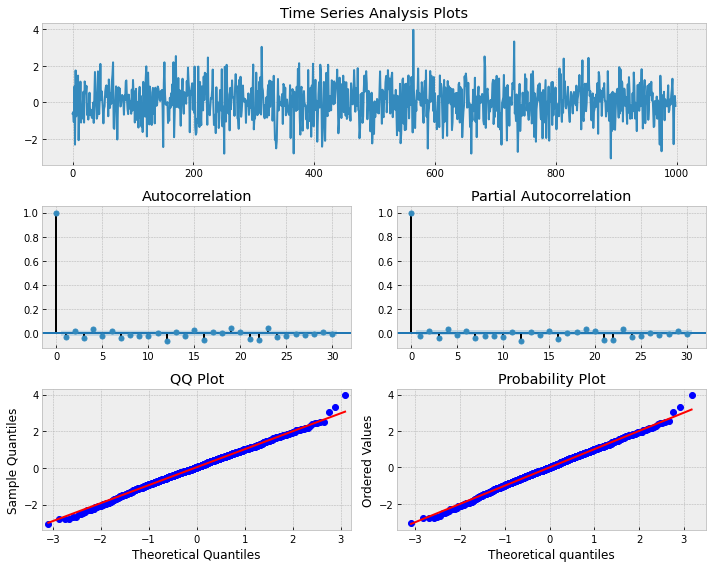

In [6]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

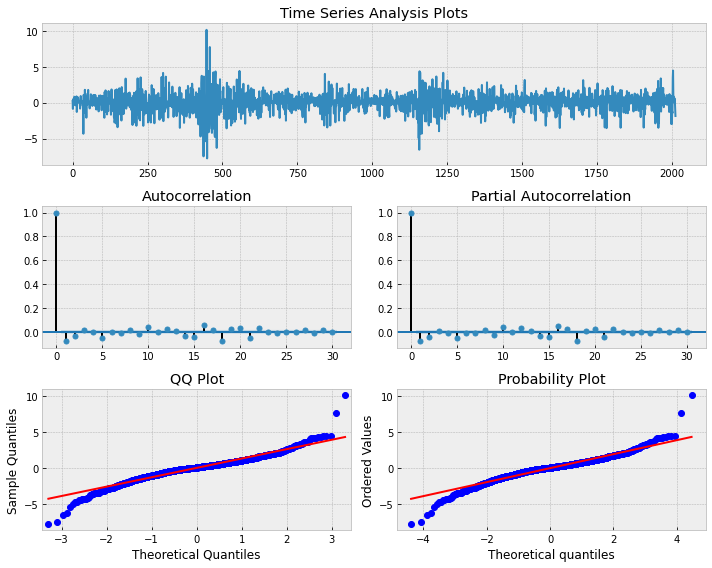

In [7]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

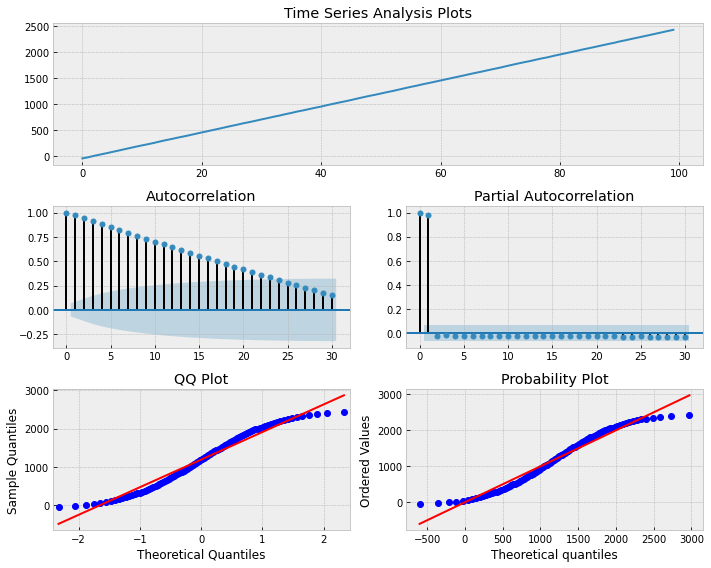

In [8]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

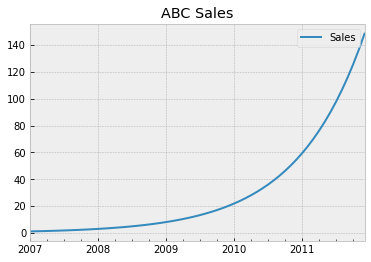

In [9]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')
    


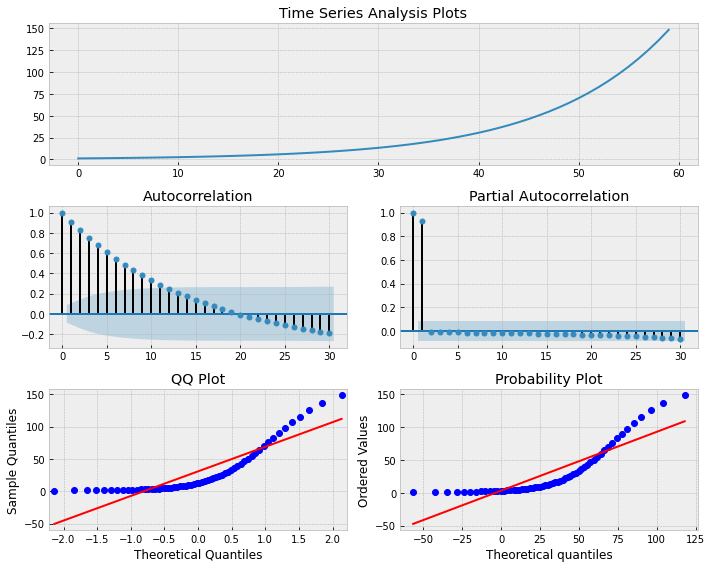

In [10]:
_ = tsplot(df.values[:,0], lags=30)  

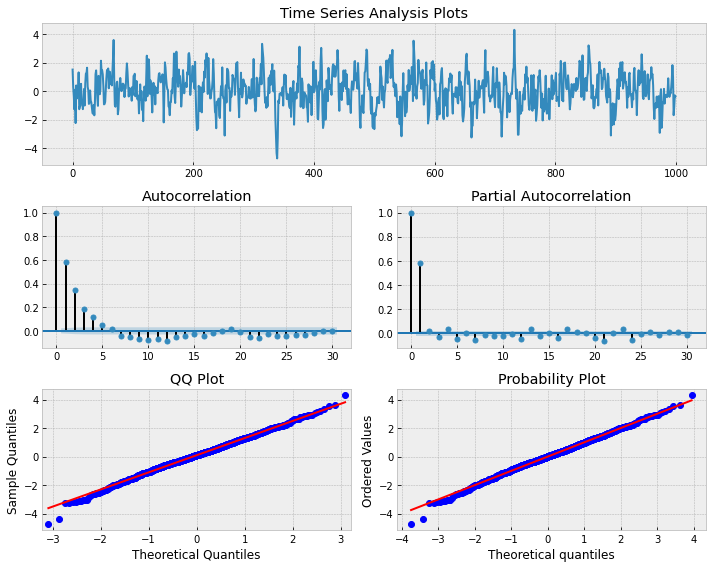

In [11]:
#让我们模拟一个alpha（等于0.6）的AR（1）模型
# Simulate an AR(1) process with alpha = 0.6
lags=30
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

In [12]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

CPU times: user 29.3 s, sys: 20.6 s, total: 50 s
Wall time: 25.3 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


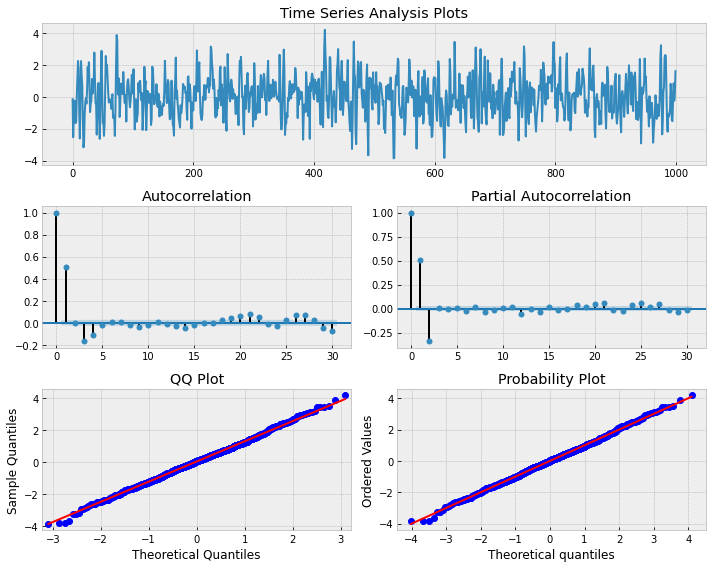

In [13]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

In [14]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [15]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 23


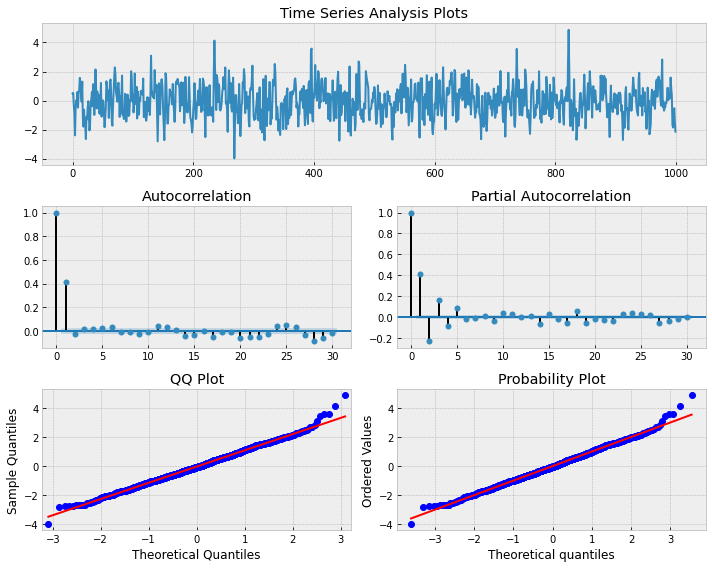

In [16]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [17]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Sat, 13 Jun 2020   AIC                           2785.025
Time:                        01:33:12   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

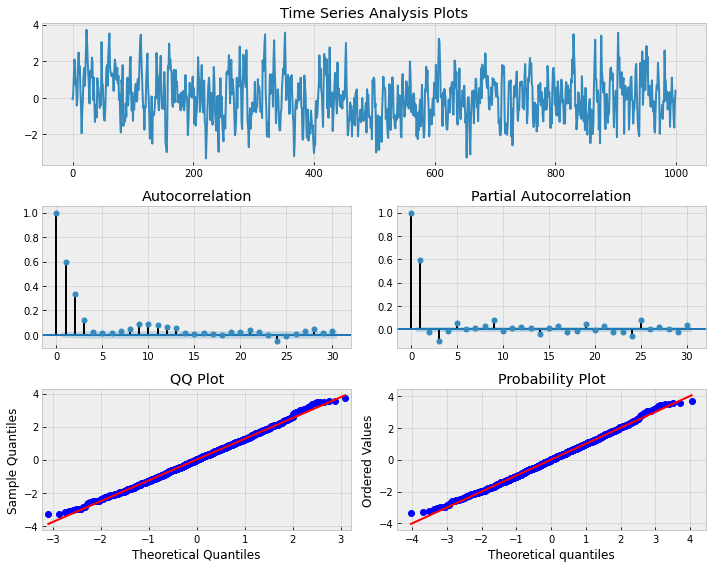

In [18]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [19]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Sat, 13 Jun 2020   AIC                           2862.075
Time:                        01:33:14   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.951
Method:                           mle   S.D. of innovations              0.014
Date:                Sat, 13 Jun 2020   AIC                         -11505.902
Time:                        01:33:14   BIC                         -11483.472
Sample:                             0   HQIC                        -11497.669
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


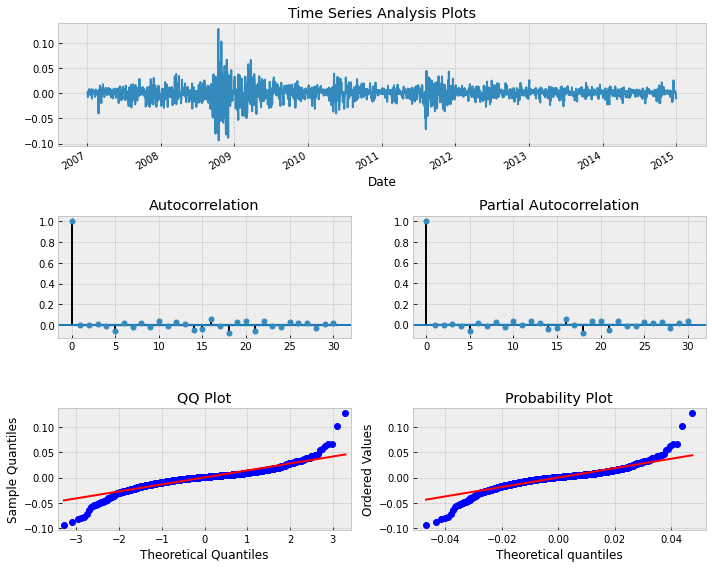

In [20]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Sat, 13 Jun 2020   AIC                          14162.352
Time:                        01:33:16   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

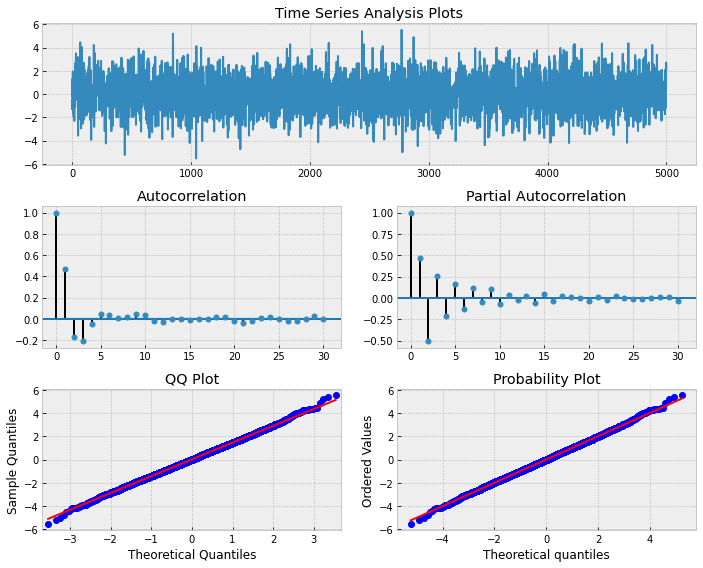

In [21]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

aic: 14212.01026 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Sat, 13 Jun 2020   AIC                          14162.352
Time:                        01:33:43   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.52

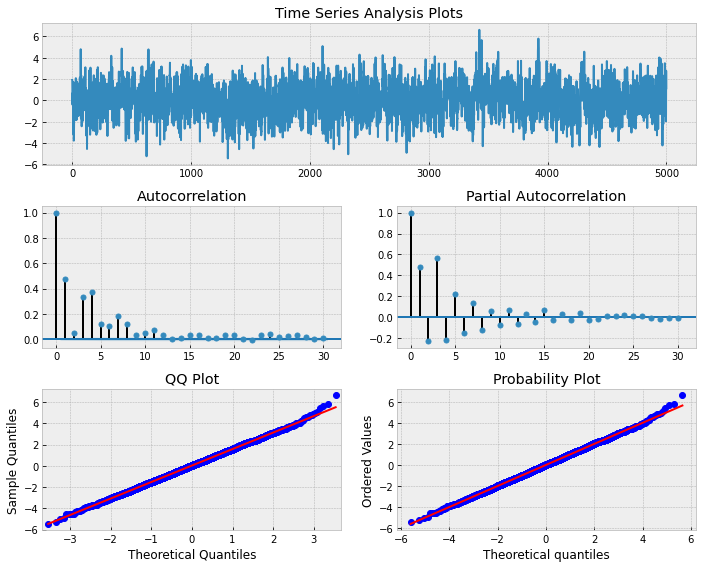

In [22]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
p(mdl.summary())
# aic: 14108.27213 | order: (3, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -11520.47028 | order: (4, 3)
                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(4, 3)   Log Likelihood                5768.235
Method:                           mle   S.D. of innovations              0.014
Date:                Sat, 13 Jun 2020   AIC                         -11520.470
Time:                        01:34:00   BIC                         -11475.611
Sample:                             0   HQIC                        -11504.004
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.6735      0.617     -1.092      0.275      -1.882       0.535
ar.L2.SPY     -0.9994      0.510     -1.960      0.050      -1.998      -0.000
ar.L3.SPY      0.0

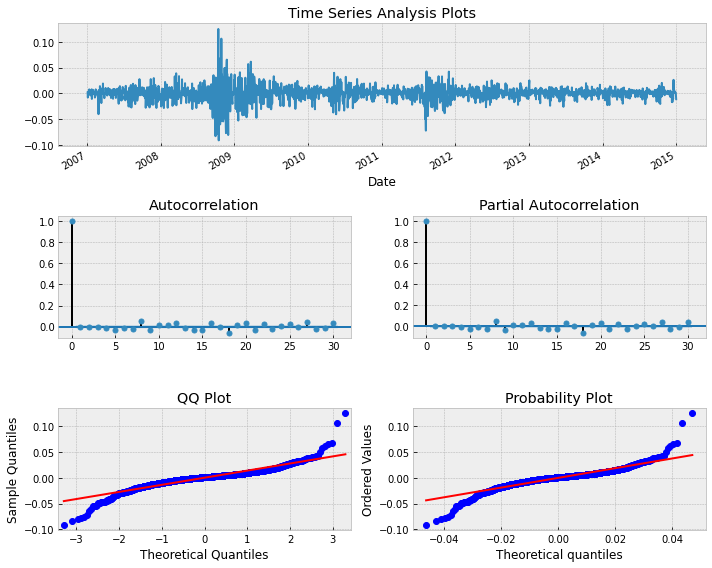

In [23]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
p(best_mdl.summary())
_ = tsplot(best_mdl.resid, lags=max_lag)
# aic: -11518.22902 | order: (4, 4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -11520.47028 | order: (4, 0, 3)


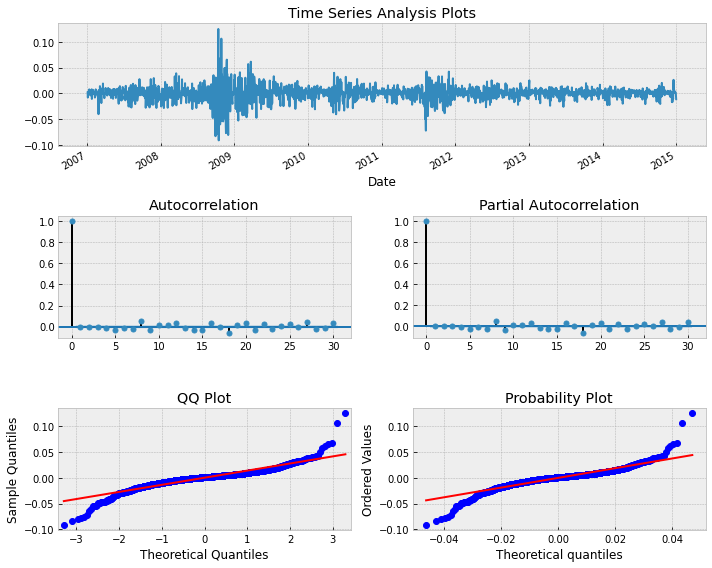

In [24]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [25]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001367,-0.025642,-0.034129,0.028376,0.036863
2015-01-01,-0.000068,-0.027192,-0.035715,0.027056,0.035579
2015-01-02,0.000230,-0.026954,-0.035495,0.027413,0.035954
2015-01-03,0.000454,-0.026736,-0.035280,0.027644,0.036187
2015-01-04,-0.000608,-0.027798,-0.036342,0.026582,0.035126


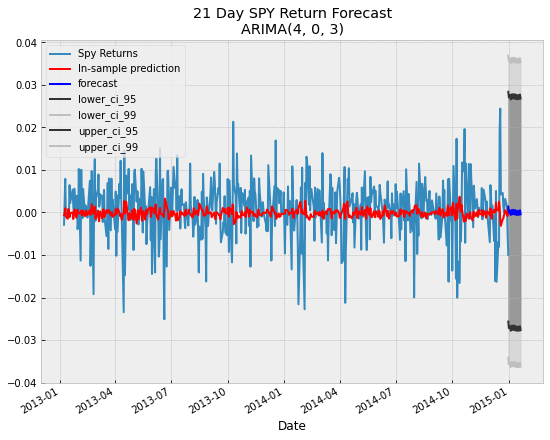

In [26]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

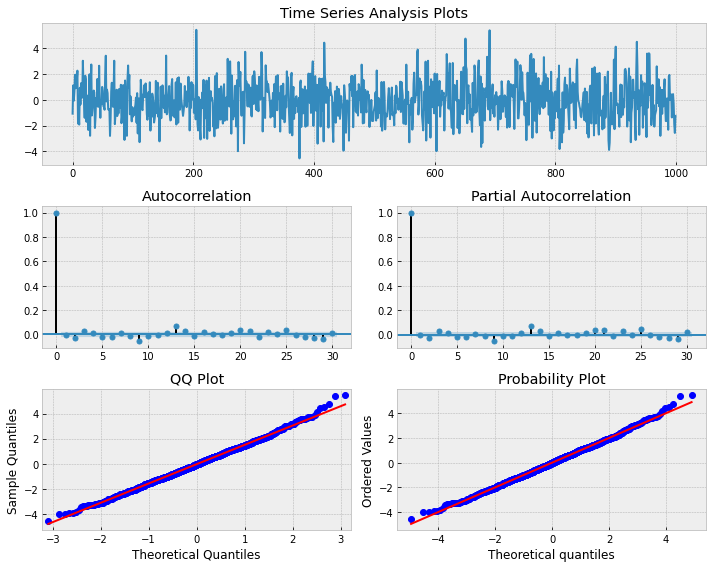

In [27]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

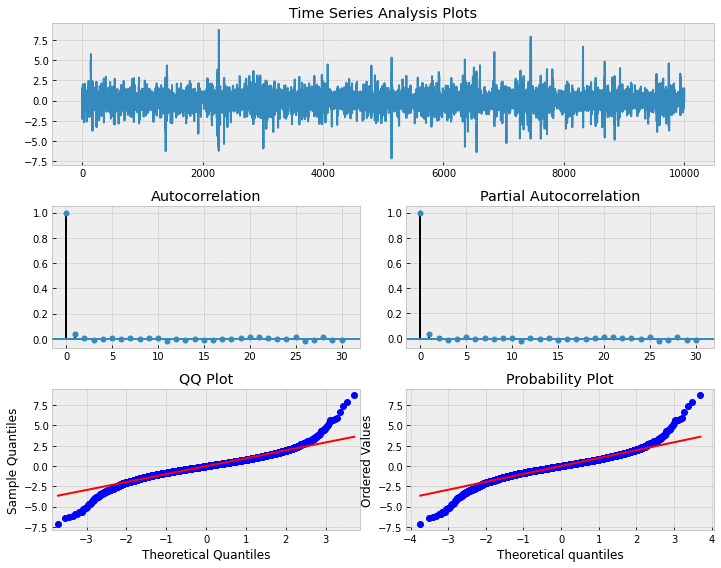

In [28]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

In [29]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sat, Jun 13 2020   Df Residuals:                     9996
Time:       

In [30]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY['2012':'2015']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -5255.56660 | order: (3, 0, 2)


/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.424e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                      -0.062
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.062
Vol Model:                            GARCH   Log-Likelihood:               -735.767
Distribution:      Standardized Student's t   AIC:                           1491.53
Method:                  Maximum Likelihood   BIC:                           1537.79
                                              No. Observations:                  754
Date:                      Sat, Jun 13 2020   Df Residuals:                      744
Time:                              01:57:21   Df Model:                           10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

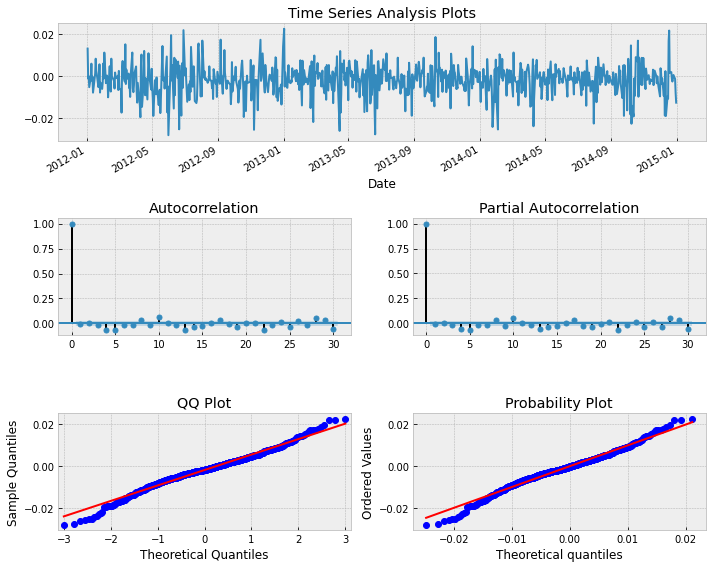

In [39]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())
_ = tsplot(res.resid, lags=max_lag)